<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-1" data-toc-modified-id="Case-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 1</a></span><ul class="toc-item"><li><span><a href="#Evaluation-metrics" data-toc-modified-id="Evaluation-metrics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Evaluation metrics</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Define-the-graph-Laplacian-operator" data-toc-modified-id="Define-the-graph-Laplacian-operator-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define the graph Laplacian operator</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Model training</a></span><ul class="toc-item"><li><span><a href="#plot-the-estimation-result" data-toc-modified-id="plot-the-estimation-result-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>plot the estimation result</a></span></li></ul></li></ul></li><li><span><a href="#Case-2--Seattle-Sensor-Network" data-toc-modified-id="Case-2--Seattle-Sensor-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Case 2--Seattle Sensor Network</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define the model</a></span></li></ul></li></ul></div>

**In this notebook, we will explore the performance of ST-INR in more challenging tasks. We consider the network-wide traffic state estimation problem where partially observed traffic states are given as training data and the model is optimized to generate the unobserved states.**  We consider two kinds of scenarios:

- Highway sensor-based traffic speed estimation where a fraction of sensors are completely removed for evaluation;
- Urban link-based traffic speed estimation where a fraction of link states are completely removed for evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

from torch import nn, optim 
import numpy as np 
import scipy.io
from typing import Optional,List
import torch
import math
from torch import Tensor
import torch.nn.functional as F
import pickle
import copy
# from adjacent_matrix_norm import *

dtype = torch.cuda.FloatTensor

## Case 1

### Evaluation metrics

In [2]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_wmape(var, var_hat):
    return np.sum(np.abs(var - var_hat)) / np.sum(var)

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def compute_mae(var, var_hat):
    return np.sum(np.abs((var - var_hat))) / var.shape[0]

def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

### Load the data

In [3]:
def load_pkl(pickle_file: str) -> object:
    try:
        with open(pickle_file, "rb") as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError:
        with open(pickle_file, "rb") as f:
            pickle_data = pickle.load(f, encoding="latin1")
    except Exception as e:
        print("Unable to load data ", pickle_file, ":", e)
        raise
    return pickle_data


def load_adj(file_path: str, adj_type: str):
    try:
        # METR and PEMS_BAY
        _, _, adj_mx = load_pkl(file_path)
        # Make the adjacent matrix symmetric by taking the max.
        adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])
    except ValueError:
        # PEMS0X
        adj_mx = load_pkl(file_path)
    if adj_type == "scalap":
        adj = [calculate_scaled_laplacian(adj_mx).astype(np.float32).todense()]
    elif adj_type == "normlap":
        adj = [calculate_symmetric_normalized_laplacian(
            adj_mx).astype(np.float32).todense()]
    elif adj_type == "symnadj":
        adj = [calculate_symmetric_message_passing_adj(
            adj_mx).astype(np.float32).todense()]
    elif adj_type == "transition":
        adj = [calculate_transition_matrix(adj_mx).T]
    elif adj_type == "doubletransition":
        adj = [calculate_transition_matrix(adj_mx).T, calculate_transition_matrix(adj_mx.T).T]
    elif adj_type == "identity":
        adj = [np.diag(np.ones(adj_mx.shape[0])).astype(np.float32)]
    elif adj_type == "original":
        adj = [adj_mx]
    else:
        error = 0
        assert error, "adj type not defined"
    return adj

In [4]:
# Bay
adj_bay = load_adj('datasets/PEMS-BAY/adj_PEMS-BAY.pkl', adj_type='original')[0]
dense_mat_bay = np.load('Datasets/PEMS-BAY/PEMS-BAY-1m.npy')
dim1, dim2 = dense_mat_bay.shape
dim = np.array([dim1, 288, 30])
dense_tensor_bay = mat2ten(dense_mat_bay, dim, 0)

##sensor missing
np.random.seed(1000)
missing_rate = 0.6
sparse_mat_bay = dense_mat_bay.copy()
missing_rows_count = int(sparse_mat_bay.shape[0] * missing_rate)
missing_rows = np.random.choice(sparse_mat_bay.shape[0], missing_rows_count, replace=False)
sparse_mat_bay[missing_rows,:] = 0
sparse_tensor_bay = mat2ten(sparse_mat_bay, dim, 0)

sparse_tensor_bay.shape,adj_bay.shape

((325, 288, 30), (325, 325))

### Define the model

In [5]:
class ST_INR3d(nn.Module):
    def __init__(self, u_in,r_1,r_2, r_3, mid_channel,n_inr_layers,n_fourier_feats,scales, omega):
        super(ST_INR3d, self).__init__()
        
        self.U_net = MixINR(u_in,n_inr_layers, mid_channel,r_1, n_fourier_feats,scales, omega)
        self.V_net = MixINR(1,n_inr_layers, mid_channel,r_2, n_fourier_feats,scales, omega)
        self.W_net = MixINR(1,n_inr_layers, mid_channel,r_3, n_fourier_feats,scales, omega)
        

    def forward(self, centre, U_input, V_input, W_input):
        """
        centre: (r_1,r_2, r_3)
        """
        U = self.U_net(U_input)
        V = self.V_net(V_input)
        W = self.W_net(W_input)
        
        centre = centre.permute(1,2,0) 
        centre = centre @ U.t()
        centre = centre.permute(2,1,0) 
        centre = centre @ V.t()
        centre = centre.permute(0,2,1) 
        centre = centre @ W.t()
        
        return centre
    
    
class GaussianFourierFeatureTransform(nn.Module):
    """
    Given an input of size [..., time, dim], returns a tensor of size [..., time,n_fourier_feats].
    """
    def __init__(self, input_dim: int, n_fourier_feats: int, scales: List[int]):
        super().__init__()
        torch.manual_seed(42)
        self.input_dim = input_dim
        self.n_fourier_feats = n_fourier_feats
        self.scales = scales

        n_scale_feats = n_fourier_feats // (2 * len(scales))
        assert n_scale_feats * 2 * len(scales) == n_fourier_feats, \
            f"n_fourier_feats: {n_fourier_feats} must be divisible by 2 * len(scales) = {2 * len(scales)}"
        B_size = (input_dim, n_scale_feats)
        B = torch.cat([torch.randn(B_size) * scale for scale in scales], dim=1)
        self.register_buffer('B', B)

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() >= 2, f"Expected 2 or more dimensional input (got {x.dim()}D input)"
        time, dim = x.shape[-2], x.shape[-1]

        assert dim == self.input_dim, \
            f"Expected input to have {self.input_dim} channels (got {dim} channels)"

        x = torch.einsum('... t n, n d -> ... t d', [x, self.B])
        x = 2 * math.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
    
    
class MixINR(nn.Module):
    def __init__(self, in_feats: int, layers: int, layer_size: int, out_size: int, n_fourier_feats: int, scales: float,
                 omega, dropout: Optional[float] = 0.1):
        super().__init__()
        self.features =  GaussianFourierFeatureTransform(in_feats, n_fourier_feats, scales)
        in_size = n_fourier_feats
        layers = [MLP(in_size, layer_size, dropout=dropout)] + \
                 [SineLayer(layer_size, layer_size, omega) for _ in range(layers - 1)] + \
                 [SineLayer(layer_size, out_size, omega)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        return self.layers(x)
    
class MLP(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 dropout: Optional[float] = 0.1):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(output_size)

    def forward(self, x: Tensor) -> Tensor:
        out = self._layer(x)
        return self.norm(out)

    def _layer(self, x: Tensor) -> Tensor:
        return self.dropout(torch.sin(self.linear(x)))
    

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0, bias=True,
                 is_first=False): 
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

### Define the graph Laplacian operator

Note that the original ST-INR model is designed for variables that exist in regular Euclidean space. To deal with network-level data that may exist in a graph, we consider using the eigenvector as the new basis.

In [6]:
from scipy import sparse as sp

def get_fourier(adj, k=100):
    l = laplacian(adj)
    _, u = sp.linalg.eigsh(l, k=k, which="SM")
    n = l.shape[0]
    u *= np.sqrt(n)

    return u

def laplacian(A):
    return degree_matrix(A) - A

def degree_matrix(A):
    degrees = np.array(A.sum(1)).flatten()
    if sp.issparse(A):
        D = sp.diags(degrees)
    else:
        D = np.diag(degrees)
    return D

In [7]:
u_in = 10
U_f = get_fourier(adj_bay,k=u_in)
U_f.shape,adj_bay.shape

((325, 10), (325, 325))

### Model training

In [8]:
#BAY
################### 
# Here are the hyperparameters. 
w_decay = 1  
lr_real = 0.0001
max_iter = 10000
omega =  1 
n_fourier_feats = 2048 
scales = [0.01] 
n_inr_layers = 2 
###################
X = torch.from_numpy(sparse_tensor_bay).type(dtype).cuda()
X = torch.where(torch.isnan(X), 0, X)
X_dense = torch.from_numpy(dense_tensor_bay).type(dtype).cuda()
[n_1,n_2,n_3] = X.shape

mid_channel = 512 
r_1 = min(n_1,n_2,n_3)
r_2 = min(n_1,n_2,n_3)
r_3 = min(n_1,n_2,n_3) 

mask = torch.ones(X.shape).type(dtype)
mask[X == 0] = 0 

In [9]:
centre = torch.Tensor(r_1,r_2, r_3).type(dtype)
stdv = 1 / math.sqrt(centre.size(0))
centre.data.uniform_(-stdv, stdv)
U_input = torch.from_numpy(U_f).type(dtype)
V_input = torch.from_numpy(np.array(range(1,n_2+1))).reshape(n_2,1).type(dtype)
W_input = torch.from_numpy(np.array(range(1,n_3+1))).reshape(n_3,1).type(dtype)

model = ST_INR3d(u_in,r_1,r_2,r_3, mid_channel,n_inr_layers,n_fourier_feats,scales,omega).type(dtype)
params = []
params += [x for x in model.parameters()]
centre.requires_grad=True
params += [centre]
optimizier = optim.Adam(params, lr=lr_real, weight_decay=w_decay) 

pos_test = torch.where((X_dense != 0) & (X == 0))
import time
start = time.time()

loss_record = []
test_loss = []
for iter in range(max_iter):
    X_Out = model(centre, U_input, V_input, W_input)
    loss = torch.norm(X_Out*mask-X*mask,2)
    optimizier.zero_grad()
    loss.backward(retain_graph=True)
    optimizier.step()
    loss_record.append(loss.detach().cpu().numpy())
    
    mae = torch.sum(torch.abs((X_dense[pos_test] - X_Out[pos_test]))) / X_Out[pos_test].shape[0]
    test_loss.append(mae.detach().cpu().numpy())
    if mae == torch.from_numpy(min(test_loss)):
        best_model = copy.deepcopy(model.state_dict())
    
end = time.time()
print('Running time: %d seconds.'%(end - start))
idx = test_loss == min(test_loss)
print('Best model result:',np.array(test_loss)[idx])

Running time: 45 seconds.
Best model result: [4.267553]


In [10]:
model.load_state_dict(best_model)
X_Out = model(centre, U_input, V_input, W_input)
tensor_hat_ginr = X_Out.cpu().detach().numpy()

pos_test = np.where((dense_tensor_bay != 0) & (sparse_tensor_bay == 0))
print('WAPE: {:.6}'.format(compute_wmape(dense_tensor_bay[pos_test], 
                                                    tensor_hat_ginr[pos_test])))
print('RMSE: {:.6}'.format(compute_rmse(dense_tensor_bay[pos_test], 
                                        tensor_hat_ginr[pos_test])))

print('MAE:  {:.6}'.format(compute_mae(dense_tensor_bay[pos_test], 
                                        tensor_hat_ginr[pos_test])))

WAPE: 0.0677262
RMSE: 6.96802
MAE:  4.24209


#### plot the estimation result

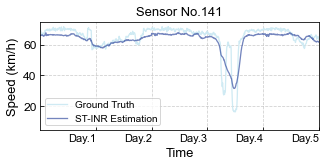

In [11]:
sensornum=np.random.choice(sparse_mat_bay.shape[0])

dataplot = dense_tensor_bay[sensornum,:,7:12].flatten('F')
imputed = tensor_hat_ginr[sensornum,:,7:12].flatten('F')
plt.figure(figsize=(5,2))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--',alpha=0.6)
plt.tick_params(labelsize=12)
plt.xlim(0,144*5)
plt.plot(dataplot,label = 'Ground Truth',linewidth=1.3,color = np.array([202,232,242])/255,alpha=0.9)
plt.plot(imputed,label = 'ST-INR Estimation',linewidth=1.3,color = np.array([57,81,162])/255,alpha=0.7)
plt.xlabel('Time',fontsize=13)
plt.title('Sensor No.'+str(sensornum),fontsize=13)
plt.ylabel('Speed (km/h)',fontsize=13)
axis = plt.gca()
axis.set_xticks([i*144 for i in range(1,6)])
axis.set_xticklabels(['Day.'+str(i) for i in range(1,6)],ha='right',fontsize=11)
plt.legend(borderpad=0.2)

## Case 2--Seattle Sensor Network

In [12]:
import numpy as np
np.random.seed(1000)

dense_tensor_seattle = np.load('datasets/Seattle/tensor.npz')['arr_0']
dim = dense_tensor_seattle.shape
dense_mat = dense_tensor_seattle.reshape([dim[0], dim[1] * dim[2]])
adj_seattle = np.load('datasets/Seattle/Loop_Seattle_2015_A.npy').astype(np.float32)

sparse_mat = dense_mat.copy()
np.random.seed(1000)
missing_rate = 0.8
missing_rows_count = int(sparse_mat.shape[0] * missing_rate)
missing_rows = np.random.choice(sparse_mat.shape[0], missing_rows_count, replace=False)
sparse_mat[missing_rows,:] = 0
print((sparse_mat==0).sum() / sparse_mat.size)

dim1, dim2 = dense_mat.shape
dim = np.array([dim1, 288, 28])
sparse_tensor_seattle = mat2ten(sparse_mat, dim, 0)
dense_tensor_seattle = dense_tensor_seattle.transpose(0,2,1)

0.7987616099071208


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


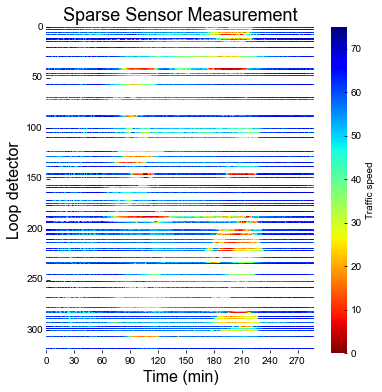

In [13]:
import seaborn as sns

T = 12
sparse_mat_plot = sparse_mat.copy()
sparse_mat_plot[sparse_mat<=0]=np.nan
fig = plt.figure(figsize = (6, 6))
sns.heatmap(sparse_mat_plot[:, T * 288 : (T+1) * 288], cmap='jet_r',vmin = 0, vmax = 75,cbar_kws={'label': 'Traffic speed'})
plt.xticks(np.arange(0, 288, 30), np.arange(0, 288, 30), rotation = 0)
plt.yticks(np.arange(0, 323, 50), np.arange(0,323,50), rotation = 0)
plt.xlabel('Time (min)',fontsize=16)
plt.ylabel('Loop detector',fontsize=16)
plt.title('Sparse Sensor Measurement',fontsize=18)
plt.gca().xaxis.set_ticks_position('bottom')

### Define the model

In [14]:
class ST_INR(nn.Module):
    def __init__(self, u_in,r_1,r_2,mid_channel,n_inr_layers,n_fourier_feats,scales, omega):
        super(ST_INR, self).__init__()
        
        self.U_net = MixINR(u_in,n_inr_layers, mid_channel,r_1, n_fourier_feats,scales, omega)
        self.V_net = MixINR(1,n_inr_layers, mid_channel,r_2, n_fourier_feats,scales, omega)
        

    def forward(self, centre, U_input, V_input):
        """
        centre: (r_1,r_2)
        """
        U = self.U_net(U_input) # [n1, 1]->[n1, r1]
        V = self.V_net(V_input) # [n2, 1]->[n2, r2]
        centre = centre.transpose(0,1) # (r_2,r_1)
        centre = centre @ U.t() # (r_2,n_1)
        centre = centre.transpose(0,1) # (n_1, r_2)
        centre = centre @ V.t() # (n_1, n_2)

        return centre
    
class MixINR(nn.Module):
    def __init__(self, in_feats: int, layers: int, layer_size: int, out_size: int, n_fourier_feats: int, scales: float,
                 omega, dropout: Optional[float] = 0.1):
        super().__init__()
        self.features =  GaussianFourierFeatureTransform(in_feats, n_fourier_feats, scales)
        in_size = n_fourier_feats
        layers = [MLP(in_size, layer_size, dropout=dropout)] + \
                 [SineLayer(layer_size, layer_size, omega) for _ in range(layers - 1)] + \
                 [SineLayer(layer_size, out_size, omega)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        return self.layers(x)
    
class MLP(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 dropout: Optional[float] = 0.1):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(output_size)

    def forward(self, x: Tensor) -> Tensor:
        out = self._layer(x)
        return self.norm(out)

    def _layer(self, x: Tensor) -> Tensor:
        return self.dropout(torch.sin(self.linear(x)))
    
    
class GaussianFourierFeatureTransform(nn.Module):
    """
    Given an input of size [..., time, dim], returns a tensor of size [..., time,n_fourier_feats].
    """
    def __init__(self, input_dim: int, n_fourier_feats: int, scales: List[int]):
        super().__init__()
        torch.manual_seed(42)
        self.input_dim = input_dim
        self.n_fourier_feats = n_fourier_feats
        self.scales = scales

        n_scale_feats = n_fourier_feats // (2 * len(scales))
        assert n_scale_feats * 2 * len(scales) == n_fourier_feats, \
            f"n_fourier_feats: {n_fourier_feats} must be divisible by 2 * len(scales) = {2 * len(scales)}"
        B_size = (input_dim, n_scale_feats)
        B = torch.cat([torch.randn(B_size) * scale for scale in scales], dim=1)
        self.register_buffer('B', B)

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() >= 2, f"Expected 2 or more dimensional input (got {x.dim()}D input)"
        time, dim = x.shape[-2], x.shape[-1]

        assert dim == self.input_dim, \
            f"Expected input to have {self.input_dim} channels (got {dim} channels)"

        x = torch.einsum('... t n, n d -> ... t d', [x, self.B])
        x = 2 * math.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
    
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0, bias=True,
                 is_first=False): 
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

In [15]:
################### 
# Here are the hyperparameters. 
w_decay = 1  
lr_real = 0.0001
max_iter = 10000
omega = 1 
n_fourier_feats = 2048 
scales = [0.01]
n_inr_layers = 2 
mid_channel = 1024  
###################

X = torch.from_numpy(sparse_mat).type(dtype).cuda()
X = torch.where(torch.isnan(X), 0, X)
X_dense = torch.from_numpy(dense_mat).type(dtype).cuda()
[n_1,n_2] = X.shape
r_1 = min(n_1,n_2) 
r_2 = min(n_1,n_2) 

mask = torch.ones(X.shape).type(dtype)
mask[X == 0] = 0 
X[mask == 0] = 0
(X==0).sum() / X.numel()

tensor(0.7988, device='cuda:0')

In [16]:
centre = torch.Tensor(r_1,r_2).type(dtype)
stdv = 1 / math.sqrt(centre.size(0))
centre.data.uniform_(-stdv, stdv)

u_in = 1
U_input = torch.from_numpy(np.array(range(1,n_1+1))).reshape(n_1,1).type(dtype)
V_input = torch.from_numpy(np.array(range(1,n_2+1))).reshape(n_2,1).type(dtype)

model = ST_INR(u_in,r_1,r_2,mid_channel,n_inr_layers,n_fourier_feats,scales,omega).type(dtype)
params = []
params += [x for x in model.parameters()]
centre.requires_grad=True
params += [centre]
optimizier = optim.Adam(params, lr=lr_real, weight_decay=w_decay) 

import time
start = time.time()
pos_test = torch.where((X_dense != 0) & (X == 0))

test_loss = []
for iter in range(max_iter):
    X_Out = model(centre, U_input, V_input)
    loss = torch.norm(X_Out*mask-X*mask,2)
    mae = torch.sum(torch.abs((X_dense[pos_test] - X_Out[pos_test]))) / X_Out[pos_test].shape[0]
    test_loss.append(mae.detach().cpu().numpy())
    optimizier.zero_grad()
    loss.backward(retain_graph=True)
    optimizier.step()
    if mae.detach().cpu().numpy() == min(test_loss):
        best_model = copy.deepcopy(model.state_dict())
    
end = time.time()
print('Running time: %d seconds.'%(end - start))
idx = test_loss == min(test_loss)
print('Best model result:',np.array(test_loss)[idx])

Running time: 143 seconds.
Best model result: [4.4768767]


In [17]:
model.load_state_dict(best_model)
X_Out = model(centre, U_input, V_input)
mat_hat_ginr = X_Out.cpu().detach().numpy()

if np.isnan(sparse_mat).any() == False:
    ind = sparse_mat != 0
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
elif np.isnan(sparse_mat).any() == True:
    ind = ~np.isnan(sparse_mat)
    pos_test = np.where((dense_mat > 0) & (np.isnan(sparse_mat)))
    sparse_mat[np.isnan(sparse_mat)] = 0
    
print('WAPE: {:.6}'.format(compute_wmape(dense_mat[pos_test], 
                                                    mat_hat_ginr[pos_test])))
print('RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], 
                                        mat_hat_ginr[pos_test])))
print('MAE:  {:.6}'.format(compute_mae(dense_mat[pos_test], 
                                        mat_hat_ginr[pos_test])))

WAPE: 0.0814156
RMSE: 7.32254
MAE:  4.69119


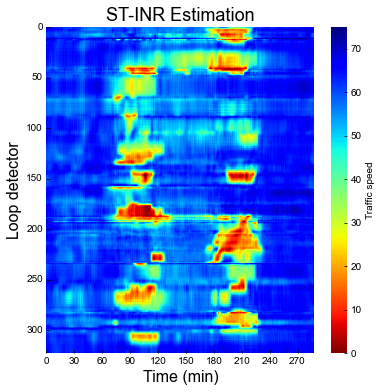

In [18]:
T = 12
sparse_mat_plot = sparse_mat.copy()
sparse_mat_plot[sparse_mat<=0]=np.nan
fig = plt.figure(figsize = (6, 6))
sns.heatmap(mat_hat_ginr[:, T * 288 : (T+1) * 288], cmap='jet_r',vmin = 0, vmax = 75,cbar_kws={'label': 'Traffic speed'})
plt.xticks(np.arange(0, 288, 30), np.arange(0, 288, 30), rotation = 0)
plt.yticks(np.arange(0, 323, 50), np.arange(0,323,50), rotation = 0)
plt.xlabel('Time (min)',fontsize=16)
plt.ylabel('Loop detector',fontsize=16)
plt.title('ST-INR Estimation',fontsize=18)
plt.gca().xaxis.set_ticks_position('bottom')